<a href="https://colab.research.google.com/github/shivsunder31/Underwater_rock_-_mine_prediction_for_submarines.ipynb/blob/main/Underwater_rock_%26_mine_prediction_for_submarines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# 1. Data Loading with Error Handling
try:
    sonar_data = pd.read_csv('/content/Copy of sonar data.csv', header=None)
except FileNotFoundError:
    print("Error: Dataset file 'Copy of sonar data.csv' not found. Please upload the file.")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

In [ ]:
# 2. Data Exploration
print("Dataset Shape:", sonar_data.shape)  # Expected: (208, 61)
print("\nClass Distribution:\n", sonar_data[60].value_counts())  # Expected: ~111 M, ~97 R
print("\nMissing Values:\n", sonar_data.isnull().sum().sum())  # Check for missing values
print("\nFeature Statistics:\n", sonar_data.iloc[:, :-1].describe())

Dataset Shape: (208, 61)

Class Distribution:
 60
M    111
R     97
Name: count, dtype: int64

Missing Values:
 0

Feature Statistics:
                0           1           2           3           4           5   \
count  208.000000  208.000000  208.000000  208.000000  208.000000  208.000000   
mean     0.029164    0.038437    0.043832    0.053892    0.075202    0.104570   
std      0.022991    0.032960    0.038428    0.046528    0.055552    0.059105   
min      0.001500    0.000600    0.001500    0.005800    0.006700    0.010200   
25%      0.013350    0.016450    0.018950    0.024375    0.038050    0.067025   
50%      0.022800    0.030800    0.034300    0.044050    0.062500    0.092150   
75%      0.035550    0.047950    0.057950    0.064500    0.100275    0.134125   
max      0.137100    0.233900    0.305900    0.426400    0.401000    0.382300   

               6           7           8           9   ...          50  \
count  208.000000  208.000000  208.000000  208.000000  ...  

In [ ]:
# 3. Data Preprocessing
X = sonar_data.drop(columns=60, axis=1)  # Features (208, 60)
Y = sonar_data[60]  # Labels (R or M)

In [ ]:
# Feature Selection: Select top 20 features using SelectKBest
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X, Y)
selected_indices = selector.get_support(indices=True)
print("\nSelected Feature Indices:", selected_indices)


Selected Feature Indices: [ 0  1  3  8  9 10 11 12 20 34 35 42 43 44 45 46 47 48 50 51]


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [ ]:
# Train-Test Split (20% test set)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, stratify=Y, random_state=42
)
print("\nTrain Shape:", X_train.shape, "Test Shape:", X_test.shape)  # Expected: (166, 20), (42, 20)



Train Shape: (166, 20) Test Shape: (42, 20)


In [ ]:
# 4. Model Training and Hyperparameter Tuning
# Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='accuracy')
lr_grid.fit(X_train, Y_train)
lr_model = lr_grid.best_estimator_
print("\nLogistic Regression Best Parameters:", lr_grid.best_params_)
print("Logistic Regression Best CV Score:", lr_grid.best_score_)



Logistic Regression Best Parameters: {'C': 1, 'solver': 'lbfgs'}
Logistic Regression Best CV Score: 0.7894830659536544


In [ ]:
# Cross-Validation
lr_cv_scores = cross_val_score(lr_model, X_train, Y_train, cv=5, scoring='accuracy')
print(f"Logistic Regression CV Accuracy: {lr_cv_scores.mean():.4f} ± {lr_cv_scores.std():.4f}")


Logistic Regression CV Accuracy: 0.7895 ± 0.0406


In [ ]:
# SVM (RBF Kernel)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, Y_train)
svm_cv_scores = cross_val_score(svm_model, X_train, Y_train, cv=5, scoring='accuracy')
print(f"SVM CV Accuracy: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")


SVM CV Accuracy: 0.7717 ± 0.0622


In [ ]:
# 5. Model Evaluation
# Logistic Regression
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
lr_train_accuracy = accuracy_score(Y_train, lr_train_pred)
lr_test_accuracy = accuracy_score(Y_test, lr_test_pred)
print("\nLogistic Regression Training Accuracy:", lr_train_accuracy)
print("Logistic Regression Test Accuracy:", lr_test_accuracy)
print("\nLogistic Regression Classification Report:\n", classification_report(Y_test, lr_test_pred))


Logistic Regression Training Accuracy: 0.8072289156626506
Logistic Regression Test Accuracy: 0.7857142857142857

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           M       0.74      0.91      0.82        22
           R       0.87      0.65      0.74        20

    accuracy                           0.79        42
   macro avg       0.80      0.78      0.78        42
weighted avg       0.80      0.79      0.78        42



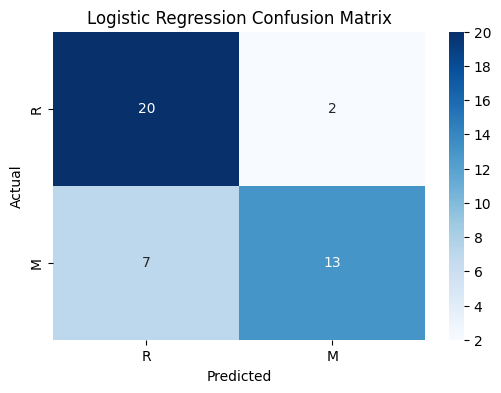

In [ ]:
# Confusion Matrix Visualization
lr_cm = confusion_matrix(Y_test, lr_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['R', 'M'], yticklabels=['R', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('lr_confusion_matrix.png')  # Save for portfolio
plt.show()

In [ ]:
# SVM
svm_test_pred = svm_model.predict(X_test)
svm_test_accuracy = accuracy_score(Y_test, svm_test_pred)
print("\nSVM Test Accuracy:", svm_test_accuracy)
print("\nSVM Classification Report:\n", classification_report(Y_test, svm_test_pred))



SVM Test Accuracy: 0.8095238095238095

SVM Classification Report:
               precision    recall  f1-score   support

           M       0.75      0.95      0.84        22
           R       0.93      0.65      0.76        20

    accuracy                           0.81        42
   macro avg       0.84      0.80      0.80        42
weighted avg       0.84      0.81      0.80        42



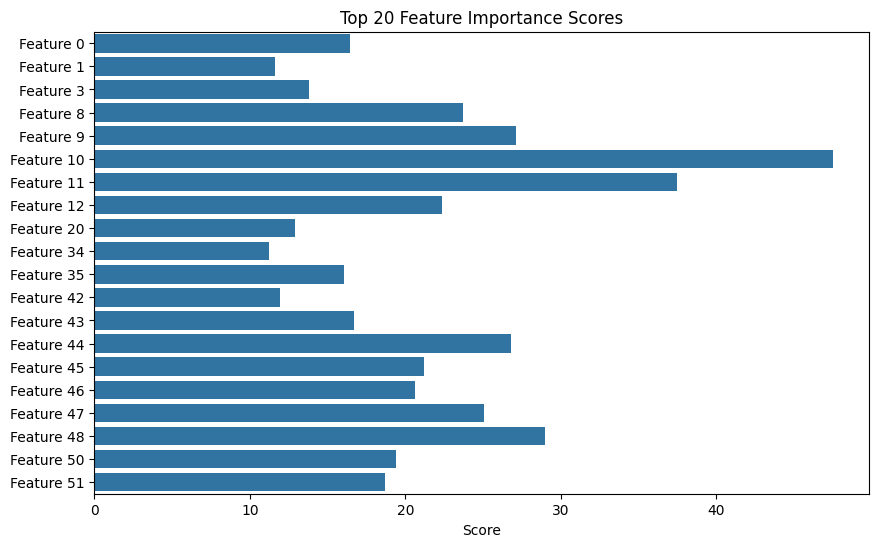

In [ ]:
# 6. Feature Importance Visualization (based on SelectKBest scores)
feature_scores = selector.scores_[selected_indices]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_scores, y=[f'Feature {i}' for i in selected_indices])
plt.title('Top 20 Feature Importance Scores')
plt.xlabel('Score')
plt.savefig('feature_importance.png')  # Save for portfolio
plt.show()

In [ ]:
# 7. Prediction on New Data with Error Handling
input_data = (0.0307, 0.0523, 0.0653, 0.0521, 0.0611, 0.0577, 0.0665, 0.0664, 0.1460, 0.2792,
              0.3877, 0.4992, 0.4981, 0.4972, 0.5607, 0.7339, 0.8230, 0.9173, 0.9975, 0.9911,
              0.8240, 0.6498, 0.5980, 0.4862, 0.3150, 0.1543, 0.0989, 0.0284, 0.1008, 0.2636,
              0.2694, 0.2930, 0.2925, 0.3998, 0.3660, 0.3172, 0.4609, 0.4374, 0.1820, 0.3376,
              0.3342, 0.5176, 0.4779, 0.4258, 0.2641, 0.1386, 0.1323, 0.2053, 0.2327, 0.2118,
              0.0899, 0.0958, 0.0902, 0.0793, 0.0726, 0.0712, 0.0676, 0.0603, 0.0532, 0.0055)

try:
    if len(input_data) != 60:
        raise ValueError("Input data must have exactly 60 features.")
    input_data_selected = np.array(input_data)[selected_indices].reshape(1, -1)  # Select same features
    input_data_scaled = scaler.transform(input_data_selected)  # Apply scaling
    lr_prediction = lr_model.predict(input_data_scaled)
    print("\nLogistic Regression Prediction:", lr_prediction[0])
    print("Object is a", "Rock" if lr_prediction[0] == 'R' else "Mine")
except Exception as e:
    print(f"Error in prediction: {e}")


Logistic Regression Prediction: M
Object is a Mine


In [ ]:
input_data = (
    0.0200, 0.0371, 0.0428, 0.0207, 0.0954, 0.0986, 0.1539, 0.1601, 0.3109, 0.2111,
    0.1609, 0.1582, 0.2238, 0.0645, 0.0660, 0.2273, 0.3100, 0.2999, 0.5078, 0.4797,
    0.5783, 0.5071, 0.4328, 0.5550, 0.6711, 0.6415, 0.7104, 0.8080, 0.6791, 0.3857,
    0.1307, 0.2604, 0.5121, 0.7547, 0.8537, 0.8507, 0.6692, 0.6097, 0.4943, 0.2744,
    0.0510, 0.2834, 0.2825, 0.4256, 0.2641, 0.1386, 0.1051, 0.1343, 0.0383, 0.0324,
    0.0232, 0.0027, 0.0065, 0.0159, 0.0072, 0.0167, 0.0180, 0.0084, 0.0090, 0.0032
)
try:
    if len(input_data) != 60:
        raise ValueError("Input data must have exactly 60 features.")
    input_data_selected = np.array(input_data)[selected_indices].reshape(1, -1)  # Select same features
    input_data_scaled = scaler.transform(input_data_selected)  # Apply scaling
    lr_prediction = lr_model.predict(input_data_scaled)
    print("\nLogistic Regression Prediction:", lr_prediction[0])
    print("Object is a", "Rock" if lr_prediction[0] == 'R' else "Mine")
except Exception as e:
    print(f"Error in prediction: {e}")


Logistic Regression Prediction: R
Object is a Rock
